# Advanced Analytics Prototyping
This notebook is used to experiment with Clustering (DTW) and Anomaly Detection (Isolation Forest) for the Teacher Salaries Dashboard.

In [24]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import mlflow
from src.salary_data.scraper import Scraper

# TS and ML libraries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.ensemble import IsolationForest

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Data Loading & Preprocessing
Fetch the data and calculate real salaries for all provinces.

In [25]:
scraper = Scraper()
START_LIMIT = '2016-12-01'

df_nom = scraper.get_cgecse_salaries(scraper.URL_TESTIGO_NETO).loc[START_LIMIT:]
df_nom.drop(["Promedio Ponderado (MG Total)"], axis=1, inplace=True)
df_ipc = scraper.get_ipc_indec().loc[START_LIMIT:]

# Calculate real salaries (Base: Last available date)
df_real = scraper.calculate_real_salary(df_nom, df_ipc['infl_Nivel_general'])
df_real.head()

jurisdiction,Buenos Aires,Catamarca,Chaco,Chubut,Ciudad de Buenos Aires,Córdoba,Corrientes,Entre Ríos,Formosa,Jujuy,...,Neuquén,Río Negro,Salta,San Juan,San Luis,Santa Cruz,Santa Fe,Santiago del Estero,Tierra del Fuego,Tucumán
2016-12-01,1142254.250,9.530151e+05,1297919.375,1631186.000,1288350.625,1661911.250,1086695.625,1125644.875,927494.0000,1126721.500,...,1849560.125,1382559.00,1567924.500,1082845.250,1613119.625,1959569.125,1502748.000,8.851076e+05,1834307.625,1235818.500
2017-03-01,1260491.000,1.031565e+06,1305126.500,1547505.875,1275294.125,1596619.250,1113348.375,1128150.125,948818.8125,1239438.500,...,1432500.000,1486031.50,1641706.750,1228972.875,1922883.875,1856870.500,1492221.875,9.488188e+05,1890918.500,1329704.000
2017-06-01,1133676.250,9.789934e+05,1294354.125,1541701.625,1210301.125,1515250.625,1077556.250,1106417.750,900464.0625,1176272.875,...,1617412.625,1460265.75,1669736.250,1166340.750,1824887.875,1762238.750,1416173.625,9.004641e+05,1814106.250,1261938.125
2017-09-01,1251419.750,1.059750e+06,1256376.125,1568915.500,1223075.125,1535973.625,1172504.875,1176230.250,955487.3125,1237245.125,...,1665451.500,1473911.25,1660244.000,1162927.750,1849228.875,1763732.250,1444285.375,9.416481e+05,1786532.125,1341047.625
2017-12-01,1144206.125,9.984076e+05,1183651.750,1478100.000,1186326.250,1465407.125,1139054.500,1108145.000,900179.5625,1223139.625,...,1471690.875,1388595.00,1612044.625,1345934.625,2054947.000,1705975.500,1360684.000,1.554667e+06,1683120.000,1263422.125


## 2. Clustering with Dynamic Time Warping (DTW)
Group provinces by their behavioral patterns.

In [26]:
# Prepare data for tslearn (needs shape: n_series, n_timestamps, 1)
X = df_real.T.values
X_scaled = TimeSeriesScalerMeanVariance().fit_transform(X)

n_clusters = 3
dba_km = TimeSeriesKMeans(n_clusters=n_clusters, 
                          metric="dtw", 
                          max_iter=10, 
                          random_state=42)
labels = dba_km.fit_predict(X_scaled)

df_clusters = pd.DataFrame({"province": df_real.columns, "cluster": labels})
df_clusters.sort_values("cluster")

,province,cluster
21,Santiago del Estero,0
2,Chaco,0
6,Corrientes,0
8,Formosa,0
9,Jujuy,0
14,Neuquén,0
15,Río Negro,0
23,Tucumán,1
3,Chubut,1
4,Ciudad de Buenos Aires,1


### 2.1 Visualize Clusters & Centroids
Plot the real salary trends faceted by cluster, and the representative average (centroid) for each group.

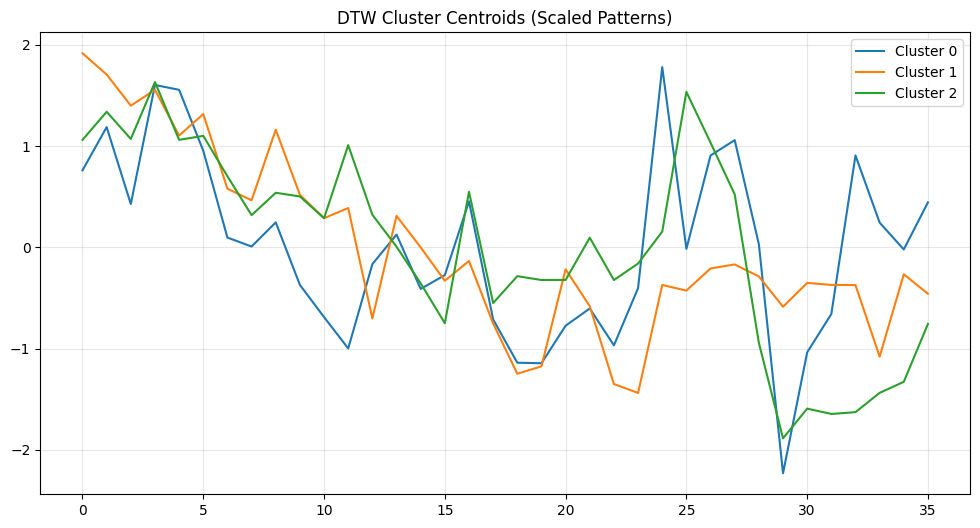

In [27]:
# Prepare data for plotting
df_plot = df_real.copy()
df_long = df_plot.T.reset_index()
# Ensure the first column (the former index) is named 'province'
df_long = df_long.rename(columns={df_long.columns[0]: 'province'})

df_long = df_long.merge(df_clusters, on='province').melt(id_vars=['province', 'cluster'], var_name='date', value_name='real_salary')
df_long['date'] = pd.to_datetime(df_long['date'])

# 1. Faceted Line Plot
fig_clusters = px.line(df_long, x='date', y='real_salary', color='province', 
                       facet_row='cluster', title='Real Salary Trends by Cluster', 
                       height=900, template='plotly_white')
fig_clusters.update_layout(showlegend=False)
fig_clusters.show()

# 2. Plot Centroids (The average 'shape' of each cluster)
plt.figure(figsize=(12, 6))
for i in range(n_clusters):
    plt.plot(dba_km.cluster_centers_[i].ravel(), label=f'Cluster {i}')
plt.title('DTW Cluster Centroids (Scaled Patterns)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 2.2 Economic Behavior Analysis
Analyze clusters by comparing the average real salary against its volatility (Standard Deviation). This helps identify if clusters represent 'Stability' or 'Crisis' patterns.

In [28]:
df_stats = pd.DataFrame({
    'mean_salary': df_real.mean(),
    'volatility': df_real.std(),
    'cluster': labels.astype(str) # Convert to string to force categorical traces
}).reset_index()

# Ensure the first column (the former index) is named 'province' for the plot
df_stats = df_stats.rename(columns={df_stats.columns[0]: 'province'})

fig_stats = px.scatter(df_stats, x='mean_salary', y='volatility', color='cluster', 
                       text='province', title='Economic Behavior: Mean Salary vs. Volatility by Cluster',
                       labels={'mean_salary': 'Average Real Salary', 'volatility': 'Volatility (Std Dev)', 'cluster': 'Cluster'},
                       category_orders={'cluster': sorted(df_stats['cluster'].unique())}, # Keep clusters sorted
                       template='plotly_white')

# Add Buttons for Interactivity
n_traces = len(fig_stats.data)
fig_stats.update_layout(
    updatemenus=[
        # 1. Toggle Labels
        dict(
            type="buttons", direction="right", x=0.1, y=1.15, showactive=True,
            buttons=[
                dict(label="Show Names", method="update", args=[{"mode": "markers+text"}]),
                dict(label="Hide Names", method="update", args=[{"mode": "markers"}])
            ]
        ),
        # 2. Filter Clusters
        dict(
            type="dropdown", direction="down", x=0.4, y=1.15, showactive=True,
            buttons=[
                dict(label="All Clusters", method="update", args=[{"visible": [True] * n_traces}]),
                *[dict(label=f"Cluster {i}", method="update", 
                       args=[{"visible": [True if j == i else False for j in range(n_traces)]}]) 
                  for i in range(n_traces)]
            ]
        )
    ]
)

fig_stats.update_traces(textposition='top center')
fig_stats.show()

## 2.3 Advanced Clustering: Shape & Dynamics
If raw DTW doesn't show a clear elbow, it's often because the magnitude or general trend dominates. Here we try:
1. **K-Shape**: A shape-based clustering algorithm that is invariant to scale.
2. **Returns Clustering**: Clustering on percentage changes to focus on shocks.

Cluster counts (K-Shape):
 cluster_kshape
1    14
0     8
2     2
Name: count, dtype: int64

Cluster counts (Returns):
 cluster_returns
2    13
0    10
1     1
Name: count, dtype: int64


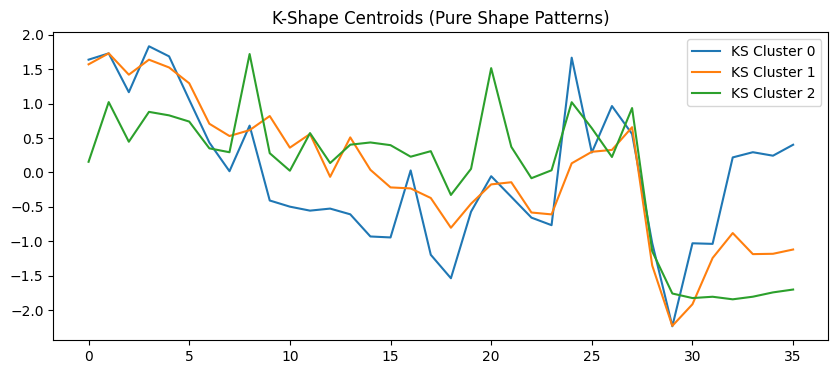

In [29]:
from tslearn.clustering import KShape

# 1. K-Shape Clustering
ks = KShape(n_clusters=3, verbose=False, random_state=42)
ks_labels = ks.fit_predict(X_scaled)

# 2. Returns-Based Clustering (Percentage changes)
df_returns = df_real.pct_change().fillna(0).T
X_ret = df_returns.values[:, :, np.newaxis]
rt_km = TimeSeriesKMeans(n_clusters=3, metric="dtw", random_state=42)
rt_labels = rt_km.fit_predict(X_ret)

df_advanced = pd.DataFrame({
    "province": df_real.columns,
    "cluster_kshape": ks_labels,
    "cluster_returns": rt_labels
})

print("Cluster counts (K-Shape):\n", df_advanced['cluster_kshape'].value_counts())
print("\nCluster counts (Returns):\n", df_advanced['cluster_returns'].value_counts())

# Visualize K-Shape Centroids
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.plot(ks.cluster_centers_[i].ravel(), label=f'KS Cluster {i}')
plt.title('K-Shape Centroids (Pure Shape Patterns)')
plt.legend()
plt.show()

In [37]:
df_advanced

,province,cluster_kshape,cluster_returns
0,Buenos Aires,2,2
1,Catamarca,1,0
2,Chaco,0,2
3,Chubut,1,0
4,Ciudad de Buenos Aires,1,0
5,Córdoba,1,0
6,Corrientes,0,0
7,Entre Ríos,1,0
8,Formosa,0,2
9,Jujuy,1,2


### Interpretation Guide:
* **No Elbow (Monotonic Silhouette):** This often means your data is a 'continuum'. There aren't discrete groups, but rather a gradient of behaviors. In this case, choose $K$ based on **interpretability** (e.g., $K=3$ for 'High Stability', 'Moderate', 'Crisis-Prone') rather than just a metric.
* **Soft-DTW increasing:** Soft-DTW is smoother; an increasing silhouette might suggest it's finding very small, fine-grained sub-patterns. Be careful of overfitting.
* **K-Shape:** If K-Shape results in one giant cluster and two tiny ones, your provinces are likely too synchronized (national policy shocks dominate local variation).

## 3. Anomaly Detection with Isolation Forest
Detect sharp drops or spikes in real purchasing power.

In [43]:
# Example: Prototyping for a single province first, then expanding to a flattened multi-province approach
prov = "Buenos Aires"
df_prov = pd.DataFrame(index=df_real.index)
df_prov['real_val'] = df_real[prov]
df_prov['pct_change'] = df_prov['real_val'].pct_change().fillna(0)

iso = IsolationForest(contamination=0.05, random_state=42)
df_prov['anomaly'] = iso.fit_predict(df_prov[['pct_change']])

fig = px.line(df_prov, y="real_val", title=f"Anomalies in {prov}")
anomalies = df_prov[df_prov['anomaly'] == -1]
fig.add_scatter(x=anomalies.index, y=anomalies['real_val'], mode='markers', name='Anomaly')
fig.show()

## 4. MLflow Local Setup
Test logging an experiment locally.

In [12]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("Analytics_Prototypes")

with mlflow.start_run(run_name="DTW_K3_Prototype"):
    mlflow.log_param("n_clusters", n_clusters)
    mlflow.log_metric("inertia", dba_km.inertia_)
    # Save results as artifact
    df_clusters.to_csv("clusters.csv", index=False)
    mlflow.log_artifact("clusters.csv")
    print(f"Run logged: {mlflow.active_run().info.run_id}")

2026/02/25 13:27:43 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2026/02/25 13:27:43 INFO mlflow.store.db.utils: Updating database tables
2026/02/25 13:27:44 INFO mlflow.tracking.fluent: Experiment with name 'Analytics_Prototypes' does not exist. Creating a new experiment.


Run logged: c117474061fd465b88a8d6f94960d827


# 5. Hypertuning K-Shape
Based on the inertia plot, the elbow is around K=5 or 6. We'll run a tuning loop and register the K=6 model as the best candidate.

In [39]:
import mlflow
import mlflow.sklearn
from tslearn.clustering import KShape

# Set the experiment
mlflow.set_experiment("KShape_Tuning")

n_clusters_range = range(2, 12)
ELBOW_K = 6

for k in n_clusters_range:
    with mlflow.start_run(run_name=f"KShape_K{k}"):
        ks = KShape(n_clusters=k, verbose=False, random_state=42)
        ks.fit(X_scaled)
        
        # Log params and metrics
        mlflow.log_param("n_clusters", k)
        mlflow.log_metric("inertia", ks.inertia_)
        
        # Log the model
        mlflow.sklearn.log_model(ks, f"kshape_k{k}")
        
        if k == ELBOW_K:
            # Register the model at K=6 as the 'Best_Elbow'
            model_uri = f"runs:/{mlflow.active_run().info.run_id}/kshape_k{k}"
            # Note: Model registration might require a running MLflow server
            try:
                mlflow.register_model(model_uri, "KShape_TeacherSalaries_Elbow")
                print(f"Registered K={k} as the best elbow model.")
            except Exception as e:
                print(f"Registration skipped/failed: {e}")
            
        print(f"K={k} | Inertia: {ks.inertia_:.6f}")

2026/02/25 17:19:42 INFO mlflow.tracking.fluent: Experiment with name 'KShape_Tuning' does not exist. Creating a new experiment.
2026/02/25 17:19:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:42 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html
2026/02/25 17:19:46 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:46 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserializ

K=2 | Inertia: 0.049352


2026/02/25 17:19:48 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:48 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=3 | Inertia: 0.042802


2026/02/25 17:19:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:50 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=4 | Inertia: 0.043744


2026/02/25 17:19:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:53 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=5 | Inertia: 0.031058


Successfully registered model 'KShape_TeacherSalaries_Elbow'.
2026/02/25 17:19:55 WARNING mlflow.tracking._model_registry.fluent: Run with id 9fbc9246e1be46e2b6ca9ab67f1109ab has no artifacts at artifact path 'kshape_k6', registering model based on models:/m-13f98c912703489f806180e945455f60 instead
Created version '1' of model 'KShape_TeacherSalaries_Elbow'.
2026/02/25 17:19:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:55 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


Registered K=6 as the best elbow model.
K=6 | Inertia: 0.022496


2026/02/25 17:19:57 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:57 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=7 | Inertia: 0.021385


2026/02/25 17:19:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:19:59 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=8 | Inertia: 0.020042


2026/02/25 17:20:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:20:02 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=9 | Inertia: 0.018817


2026/02/25 17:20:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/25 17:20:04 WARNING mlflow.sklearn: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization. The recommended safe alternative is the 'skops' format. For more information, see: https://scikit-learn.org/stable/model_persistence.html


K=10 | Inertia: 0.017566
K=11 | Inertia: 0.015362


# 6. Production Cluster Analysis
Load the registered 'Best Elbow' model and perform a deep dive into the 6 clusters' behaviors.

Province Distribution:
 cluster
5    9
1    6
3    3
4    3
0    2
2    1
Name: count, dtype: int64


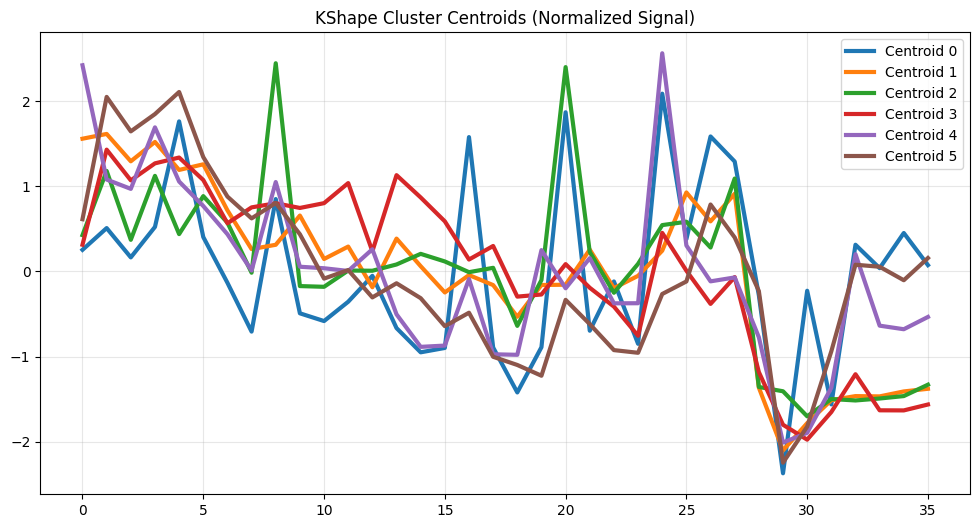

In [41]:
import mlflow.sklearn

# 1. Load the model from registry
model_name = "KShape_TeacherSalaries_Elbow"
model = mlflow.sklearn.load_model(f"models:/{model_name}/latest")
labels = model.predict(X_scaled)

df_res = pd.DataFrame({"province": df_real.columns, "cluster": labels})
print("Province Distribution:\n", df_res['cluster'].value_counts())

# 2. Prepare Long Format Data
df_long = df_real.T.reset_index().rename(columns={df_real.T.reset_index().columns[0]: 'province'})
df_long = df_long.merge(df_res, on='province').melt(id_vars=['province', 'cluster'], var_name='date', value_name='real_salary')
df_long['date'] = pd.to_datetime(df_long['date'])

# 3. Visualization 1: Salary Trends with Cluster Toggles
df_long['cluster'] = df_long['cluster'].astype(str) # Ensure cluster is string for Plotly traces
fig_trends = px.line(df_long, x='date', y='real_salary', color='cluster', line_group='province',
                     hover_name='province', title='Real Salary Trends by Cluster (K=6)',
                     template='plotly_white', color_discrete_sequence=px.colors.qualitative.Safe)

# Build visibility lists by inspecting the actual traces created
cluster_ids = sorted(df_long['cluster'].unique())
buttons = [dict(label="Show All", method="update", args=[{"visible": [True] * len(fig_trends.data)}])]

for cls_id in cluster_ids:
    # A trace is visible if its name (cluster ID) matches the selected one
    visible = [trace.name == cls_id for trace in fig_trends.data]
    buttons.append(dict(label=f"Only Cluster {cls_id}", method="update", args=[{"visible": visible}]))

fig_trends.update_layout(
    updatemenus=[
        dict(type="buttons", direction="down", x=1.15, y=0.5, showactive=True, buttons=buttons)
    ]
)
fig_trends.show()

# 4. Visualization 2: Centroid Shapes
plt.figure(figsize=(12, 6))
for i in range(model.n_clusters):
    plt.plot(model.cluster_centers_[i].ravel(), label=f'Centroid {i}', linewidth=3)
plt.title('KShape Cluster Centroids (Normalized Signal)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Visualization 3: Percentage Change (Returns) Distribution
df_ret = df_real.pct_change().fillna(0).T.reset_index().rename(columns={df_real.T.reset_index().columns[0]: 'province'})
df_ret = df_ret.merge(df_res, on='province').melt(id_vars=['province', 'cluster'], var_name='date', value_name='pct_change')

fig_ret = px.box(df_ret, x='cluster', y='pct_change', color='cluster', 
                 title='Monthly Returns Distribution by Cluster',
                 labels={'pct_change': 'Monthly % Change', 'cluster': 'Cluster'},
                 template='plotly_white')
fig_ret.show()

In [42]:
df_res

,province,cluster
0,Buenos Aires,2
1,Catamarca,1
2,Chaco,5
3,Chubut,3
4,Ciudad de Buenos Aires,5
5,Córdoba,1
6,Corrientes,5
7,Entre Ríos,1
8,Formosa,0
9,Jujuy,5
